# Kaggle Dogs vs Cats Library and Demo

This is a library to download and parse the [Kaggle's Dogs vs Cats competition](https://www.kaggle.com/competitions/dogs-vs-cats/overview) dataset and a demo of CNNs.

It's inspired on [Keras' Image classification from scratch](https://keras.io/examples/vision/image_classification_from_scratch/) demo.

The code of this notebook in one demo file is in [.../examples/dogvscats/demo/](https://github.com/gomlx/gomlx/tree/main/examples/dogsvscats/demo)

This notebook contains 3 demos for the "Dogs Vs Cats" datasets:

1. A plain CNN model. It reaches decent accuracy.
2. Transfer learning with a pre-trained InceptionV3 model -- loaded from the internet. You get the best accuracy this way.
3. ["Bootstrap Your Own Latent" (BYOL)](https://arxiv.org/abs/2006.07733) pretraining with unsupervised data (no labels) and then finetune on a few examples (1000 steps). It's a powerful technique when there is lots of data, but mostly unlabeled -- not the case here, all images are labeled, but an interesting technique and demo.

## Environment Set Up

Let's set up `go.mod` to use the local copy of GoMLX, so it can be developed jointly the dataset code with the model. That's often how data pre-processing and model code is developed together with experimentation.

If you are not changing GoMLX code, feel free to simply skip this cell. Or if you used a different directory for you projects, change it below.

Notice the directory `${HOME}/Projects/gomlx` is where the GoMLX code is copied by default in [its Docker](https://hub.docker.com/repository/docker/janpfeifer/gomlx_jupyterlab/general).

In [1]:
!*rm -f go.work && go work init && go work use . "${HOME}/Projects/gomlx"
%goworkfix

	- Added replace rule for module "github.com/gomlx/gomlx" to local directory "/home/janpf/Projects/gomlx".


## Data Preparation

The dataset takes ~790Mb compressed, and contains ~25K examples (a few are not parseable JPG), evenly split. We further separate this into 20K for training and 5K for validation/testing, randomly picked. 

GoMLX provides a dataset loading and data augmentation [library for the Kaggle Dogs vs Cats competition](https://pkg.go.dev/github.com/gomlx/gomlx@v0.1.0/examples/dogsvscats#section-readme). 
This make it easy to acess the data -- but this notebook serves as documentation and example for the library.

Let's first create the train/validation dataset, and display a sample of the augmented images. The `dogsvscats` library provide a `dogsvscats.CreateDatasets`
function that takes a `dogsvscats.PreprocessingConfiguration` and returns 3 datasets: one for training; one for evaluation on training data; one for evaluation on a validation (separate) data. Only the training data is augmented, and we use that in the cell below to sample from -- you'll notice some random rotations, and images are randomly flipped.

The first time it runs it may take a while, since it needs to download the data from the internet. The default directory for the data is `${HOME}/work/dogs_vs_cats/`, but you can change it, by setting the `--data` flag. The next time it runs it will re-use the downloaded data.

In [2]:
import (
    "github.com/gomlx/gomlx/pkg/ml/data"
    "github.com/gomlx/gomlx/pkg/ml/context"
    "github.com/gomlx/gomlx/examples/dogsvscats"
    "github.com/janpfeifer/must"
)

var (
    flagDataDir   = flag.String("data", "~/work/dogs_vs_cats", "Directory to cache downloaded and generated dataset files.")
    flagCheckpoint = flag.String("checkpoint", "", "Directory save and load checkpoints from. If left empty, no checkpoints are created.")
    contextSettings *string
)

// init_contextSettings is executed at initialization and sets the flag "set" to accept the default context setting flags.
// Use --help to see all options one can set.
func init_contextSettings() {
	ctx := dogsvscats.CreateDefaultContext()
	contextSettings = commandline.CreateContextSettingsFlag(ctx, "set")
}

// ContextFromSettings returns the default context merged with values parsed from -set flag.
// It also returns the list of parameters set with -set flag.
func ContextFromSettings() (ctx *context.Context, paramsSet []string) {
    ctx = dogsvscats.CreateDefaultContext()
    paramsSet = must.M1(commandline.ParseContextSettings(ctx, *contextSettings))
    return
}
%% 
ctx, _ := ContextFromSettings()
config := dogsvscats.NewPreprocessingConfigurationFromContext(ctx, *flagDataDir)
// Download dataset, if not yet downloaded.
must.M(dogsvscats.Download(config.DataDir))
fmt.Println("Dogs vs Cats dataset downloaded.")

Dogs vs Cats dataset downloaded.


Now that the data is downloaded we can create a `train.Dataset` and sample from it. We sample a few images and display below.

Dog (3270),Dog (11768),Dog (3312),Dog (1722),Dog (12383),Dog (1945),Dog (12437),Dog (4159)
Cat (966),Cat (10210),Cat (4770),Cat (2909),Cat (7093),Cat (8224),Cat (2431),Cat (5799)

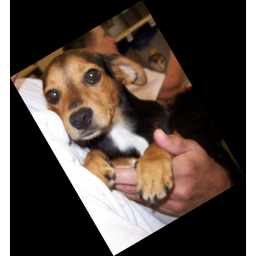
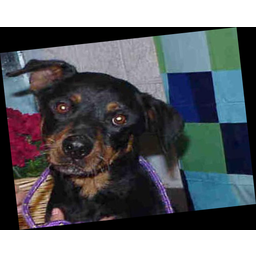
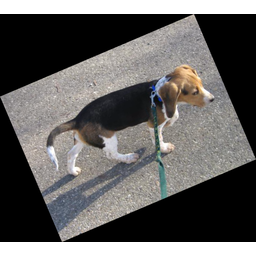
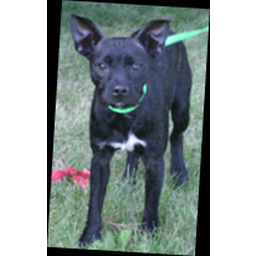
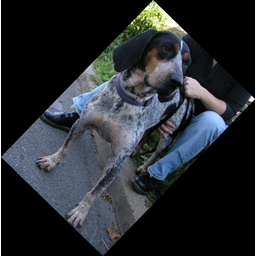
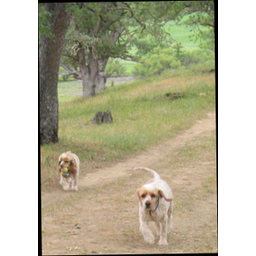
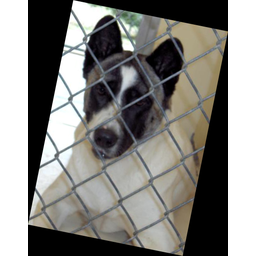
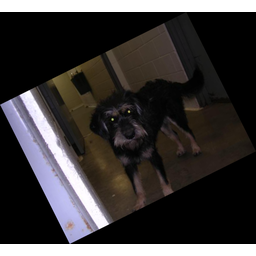
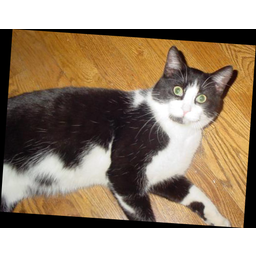
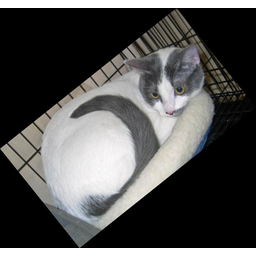
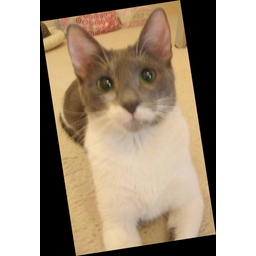
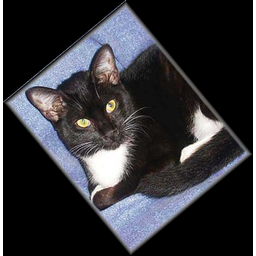
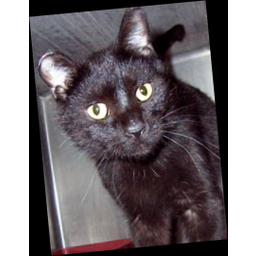
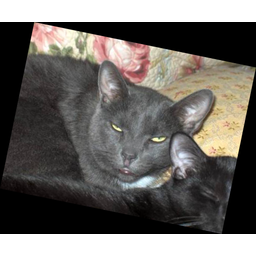
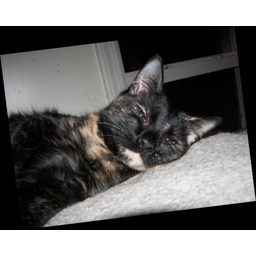
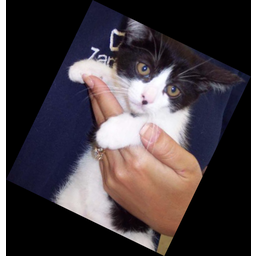

In [3]:
import(
    timage "github.com/gomlx/gomlx/pkg/core/tensors/images"
    "github.com/gomlx/gomlx/pkg/core/tensors"
    "github.com/gomlx/gomlx/pkg/ml/data"
    "github.com/gomlx/gopjrt/dtypes"

    "github.com/janpfeifer/gonb/gonbui"
)

// sample some random augmented images and display them in the Notebook.
func sample(config *dogsvscats.PreprocessingConfiguration, numRows, numPerRow int) {
    var images []image.Image
    var labels []dogsvscats.DogOrCat

    // Create datasets with batch size equals 2*numPerRow.
    var configForSample dogsvscats.PreprocessingConfiguration
    configForSample = *config
    configForSample.BatchSize = numRows*numPerRow  // Sample only what we need, in one batch.
    configForSample.ModelImageSize = 256
    configForSample.ForceOriginal = true
    configForSample.UseParallelism = true
    configForSample.DType = dtypes.Uint8
    
    // Sample the images.
    ds, _, _ := dogsvscats.CreateDatasets(&configForSample)
    _, inputsT, labelsT := must.M3(ds.Yield())
    
    // Get indices and labels of the images.
    indices := inputsT[1].Value().([]int64)
    labelsFloat := labelsT[0].Value().([]uint8)
    labels = make([]dogsvscats.DogOrCat, 0, numRows*numPerRow)
    for _, labelFloat := range labelsFloat {
        labels = append(labels, dogsvscats.DogOrCat(labelFloat))
    }
    
    // Convert images from tensor to Go images.
    images = timage.ToImage().Batch(inputsT[0])
    htmlRows := make([]string, 0, numRows)
    count := 0
    for row := 0; row < numRows; row++ {
        cells := make([]string, 0, numPerRow)
        for col := 0; col < numPerRow; col++ {
            imgIdx := indices[count]
            cells = append(cells, embedImageInHTML(images[count], labels[count].String(), imgIdx, 256))
            count++
        }
        htmlRows = append(htmlRows, fmt.Sprintf("<tr>\n\t<td>%s</td>\n</tr>", strings.Join(cells, "</td>\n\t<td>")))
    }
    htmlTable := fmt.Sprintf("<h3>%s</h3><table>%s</table>\n", "Sample Dogs vs Cats", strings.Join(htmlRows, ""))
    gonbui.DisplayHTML(htmlTable)
}

// embedImageInHTML, with a label.
func embedImageInHTML(img image.Image, label string, imgIdx int64, size int) string {
    imgSrc := must.M1(gonbui.EmbedImageAsPNGSrc(img))   // Generate image in-html (in the src filed), as opposed to a separate file.
    return fmt.Sprintf(`<figure style="padding:4px;text-align: center; background-color: lightgray; color: black;"><img src="%s" width="%dpx" height="%dpx"><figcaption style="text-align: center;">%s (%d)</figcaption></figure>`,
                       imgSrc, size, size, label, imgIdx)
}

%%
ctx, _ := ContextFromSettings()
config := dogsvscats.NewPreprocessingConfigurationFromContext(ctx, *flagDataDir)
sample(config, 2, 8)

### Pre-Generating Agumented and Scaled Images

While our dataset does parallelize the work of augmenting and scaling the images, it's still bottlenecked mostly by the transformation than by the machine learning (at least if running in an old GPU). 

So an alternative is pre-generating the augmented and scaled images, which takes space in disk, but will significantly accelerate training. 

The `gomlx/examples/dogsvscats` library provides the `PreGenerate(config *Configuration, numEpochsForTraining int)` function that does that. It will take some 10 minutes to generate 50 epochs of augmented data (~1M uniquely augmented images, or ~30000 unique batches of size 32), which is plenty to train, but takes 22Gb of space. The function `dogsvscats.CreateDatasets` will automatically use the pre-generated data if it find the files in the `--data` directory.

> **Note**: one issue with the pre-generated dataset (as its currently implemented) is that it's not shuffable: so if 
> one restarts training without going over all the 40 epochs it will see the same images over and over and will overfit to them.

This can take up to 10 minutes, but only needs to be run once. If it detects the files already exist, it's just skipped.

In [ ]:
import (
    "time"
    "github.com/gomlx/gomlx/pkg/ml/data"
    "github.com/gomlx/gomlx/pkg/ml/train"
)

// We increase the size of the batch for the generation of images -- it makes it a bit faster.
%% --set="batch_size=100"
repeats := 50
ctx, _ := ContextFromSettings()
config := dogsvscats.NewPreprocessingConfigurationFromContext(ctx, *flagDataDir)
dogsvscats.PreGenerate(config, repeats, false)

// Report on number of records from each dataset -- we need to read through them.
fmt.Println("")
for dsIdx, dsName := range []string{dogsvscats.PreGeneratedTrainFileName, dogsvscats.PreGeneratedTrainEvalFileName, dogsvscats.PreGeneratedValidationFileName} {
    fmt.Printf("Dataset %q: ... \r", dsName)
    dsPath := path.Join(config.DataDir, dsName)
    ds := dogsvscats.NewPreGeneratedDataset(dsName, dsPath, 1, false, config.ModelImageSize, config.ModelImageSize, config.DType)
    parallelDS := data.Parallel(ds)  // We want to parallelize reading from disk and parsing images to tensors.
    count := 0
    countReport := 1000
    start := time.Now()
    for {
        _, _, _, err := parallelDS.Yield()  // We are simply counting, we don't need the actual values.
        if err == io.EOF { break }
        must.M(err)  // Panic if an error.
        count++
        if count % countReport == 0 {
            fmt.Printf("Dataset %q: %d... \r", dsName, count)
        }
    }
    elapsed := time.Since(start)
    if dsIdx == 0 { // For train data, where we generate multiple augmented versions of the original image.
        fmt.Printf("Dataset %q: %d images (== %d x %d)\n", dsName, count, repeats, count/repeats)    
        fmt.Printf("\tElapsed time: %s (%s /image)\n", elapsed, elapsed/time.Duration(count))
    } else {
        fmt.Printf("Dataset %q: %d images\n", dsName, count)    
    }
}

Validation data for evaluation already generated in "/home/janpf/work/dogs_vs_cats/validation_eval_data.bin"
Training data for evaluation already generated in "/home/janpf/work/dogs_vs_cats/train_eval_data.bin"
Generating training data *with augmentation* in "/home/janpf/work/dogs_vs_cats/train_data.bin" and "/home/janpf/work/dogs_vs_cats/train_pair_data.bin"...
	Parallelism: 32
Pre-generating  48%  (1206 images/s) 43s:7m5s]        

## Training a CNN model

Our first model is a simple CNN model currently using images scaled down to 75x75 pixels, with random rotations (mean 0 and standard deviation of 5 degrees) and random flips.

### Model Hyperparameters

Defined in one place for all models, because many are used accross the training loop. See `dogsvscats.CreateDefaultContext` defined in [.../examples/dogsvscats/train.go](https://github.com/gomlx/gomlx/blob/main/examples/dogsvscats/train.go), the default values are:

In [5]:
%%
ctx, _ := ContextFromSettings()
fmt.Println(commandline.SprintContextSettings(ctx))

Context hyperparameters:
	"activation": (string) 
	"adam_dtype": (string) 
	"adam_epsilon": (float64) 1e-07
	"augmentation_angle_stddev": (float64) 20
	"augmentation_force_original": (bool) false
	"augmentation_random_flips": (bool) true
	"batch_size": (int) 16
	"byol_finetune": (bool) false
	"byol_hidden_nodes": (int) 4096
	"byol_inception": (bool) false
	"byol_pretrain": (bool) false
	"byol_projection_nodes": (int) 256
	"byol_reg_len1": (float64) 0.01
	"byol_regularization_rate": (float64) 1
	"byol_target_update_ratio": (float64) 0.99
	"cnn_dropout_rate": (float64) -1
	"cnn_embeddings_size": (int) 128
	"cnn_num_layers": (float64) 5
	"cosine_schedule_steps": (int) 0
	"dropout_rate": (float64) 0.1
	"eval_batch_size": (int) 100
	"fnn_dropout_rate": (float64) -1
	"fnn_normalization": (string) 
	"fnn_num_hidden_layers": (int) 3
	"fnn_num_hidden_nodes": (int) 128
	"fnn_residual": (bool) true
	"inception_finetuning": (bool) true
	"inception_pretrained": (bool) true
	"kan_bspline_degree": (i

### Model Definitions

GoMLX model functions have the signature:

```go
type ModelFn func(ctx *context.Context, spec any, inputs []*graph.Node) (predictions []*graph.Node)
```

- `ctx` holds the hyperparameters and variables created and used by the model.
- `spec` is an opaque value provided by the dataset. Simply ignored for this project, but it can be used to identity different types of inputs, for heterogeneous input types (e.g.: for multi-headed models)
- `inputs` is a tuple of inputs. For this dataset, the input takes only one value, a batch of images to be classified.

The function returns a tuple of predictions. For this project with only one element, the batch of predictions for the input images.

The `dogsvscats.CnnModelGraph` in [.../examples/dogsvscats/train.go](https://github.com/gomlx/gomlx/blob/main/examples/dogsvscats/model_cnn.go) is defined as:

```go
// CnnModelGraph builds the CNN model for our demo.
// It returns the logit, not the predictions, which works with most losses.
// inputs: only one tensor, with shape `[batch_size, width, height, depth]`.
func CnnModelGraph(ctx *context.Context, spec any, inputs []*Node) []*Node {
	embeddings := CnnEmbeddings(ctx, inputs[0])
	logit := fnn.New(ctx.In("readout"), embeddings, 1).NumHiddenLayers(0, 0).Done()
	return []*Node{logit}
}

func CnnEmbeddings(ctx *context.Context, images *Node) *Node {
	batchSize := images.Shape().Dimensions[0]
	numConvolutions := context.GetParamOr(ctx, "cnn_num_layers", 5)

	// Dropout.
	dropoutRate := context.GetParamOr(ctx, "cnn_dropout_rate", -1.0)
	if dropoutRate < 0 {
		dropoutRate = context.GetParamOr(ctx, layers.ParamDropoutRate, 0.0)
	}
	var dropoutNode *Node
	if dropoutRate > 0.0 {
		dropoutNode = Scalar(images.Graph(), images.DType(), dropoutRate)
	}

	filterSize := 16
	logits := images
	imgSize := logits.Shape().Dimensions[1]
	for convIdx := range numConvolutions {
		ctx := ctx.Inf("%03d_conv", convIdx)
		if convIdx > 0 {
			logits = normalizeImage(ctx, logits)
		}
		for repeat := 0; repeat < 2; repeat++ {
			ctx := ctx.Inf("repeat_%02d", repeat)
			residual := logits
			logits = layers.Convolution(ctx, logits).Filters(filterSize).KernelSize(3).PadSame().Done()
			logits = activations.ApplyFromContext(ctx, logits)
			if dropoutNode != nil {
				logits = layers.Dropout(ctx, logits, dropoutNode)
			}
			if residual.Shape().Equal(logits.Shape()) {
				logits = Add(logits, residual)
			}
		}
		if imgSize > 16 {
			// Reduce image size by 2 each time.
			logits = MaxPool(logits).Window(2).Done()
			imgSize = logits.Shape().Dimensions[1]
		}
		logits.AssertDims(batchSize, imgSize, imgSize, filterSize)
	}

	// Flatten the resulting image, and treat the convolved values as tabular.
	logits = Reshape(logits, batchSize, -1)
	return fnn.New(ctx.Inf("%03d_fnn", numConvolutions), logits, context.GetParamOr(ctx, "cnn_embeddings_size", 128)).Done()
}

func normalizeImage(ctx *context.Context, x *Node) *Node {
	x.AssertRank(4) // [batch_size, width, height, depth]
	norm := context.GetParamOr(ctx, "cnn_normalization", "")
	if norm == "" {
		context.GetParamOr(ctx, layers.ParamNormalization, "")
	}
	switch norm {
	case "layer":
		return layers.LayerNormalization(ctx, x, 1, 2).ScaleNormalization(false).Done()
	case "batch":
		return batchnorm.New(ctx, x, -1).Done()
	case "none", "":
		return x
	}
	exceptions.Panicf("invalid normalization selected %q -- valid values are batch, layer, none", norm)
	return nil
}
```

Below we do a small test that given a placeholder input, it will build the computation graph with the correct shape:

In [6]:
import (
    . "github.com/gomlx/gomlx/pkg/core/graph"
    "github.com/gomlx/gomlx/backends"

    _ "github.com/gomlx/gomlx/backends/default"
)

var _ = NewGraph

%%
ctx, _ := ContextFromSettings()
config := dogsvscats.NewPreprocessingConfigurationFromContext(ctx, *flagDataDir)

// Let's just check that we get the right shape from the model function, wihtout any real data.
g := NewGraph(backends.MustNew(), "test")
inputs := []*Node{
    // Images: create a graph parameter node shaped [batch_size, width, heigh, depth=4]:
    Parameter(g, "images", shapes.Make(config.DType, config.BatchSize, config.ModelImageSize, config.ModelImageSize, 4)),
}
outputs := dogsvscats.CnnModelGraph(ctx, nil, inputs)
fmt.Printf("Logits shape for batch_size=%d: %s\n", config.BatchSize, outputs[0].Shape())
outputs[0].AssertDims(config.BatchSize, 1)

Logits shape for batch_size=16: (Float32)[16 1]


### Training Loop

The trainer `dogsvscats.TrainModel` is defined in the [.../examples/dogsvscats/train.go](https://github.com/gomlx/gomlx/blob/main/examples/dogsvscats/train.go). It is straight forward (and almost the same for every different project) and does the following for us:

- If a checkpoing is given (--checkpoint) and it has a previously saved model, it loads hyperparmeters and trained variables.
- Create trainer: with selected model function (by default the `dogsvscasts.CnnModelGraph`), optimizer, loss and metrics.
- Create a `train.Loop` and attach to it a progressbar, a periodic checkpoint saver and a plotter (`--set="plots=true"`).
- Train the selected number of train steps.
- Report results.

Below we train 50 steps with the default settings just to check things are working.

In [7]:
%% --set="model=cnn;plots=false;train_steps=50"
ctx, paramsSet := ContextFromSettings()
dogsvscats.TrainModel(ctx, *flagDataDir, *flagCheckpoint, /* eval */ false, paramsSet)

Model: "cnn"
Training (50 steps):  100% [========================================] (10 steps/s) [step=49] [loss+=0.674] [~loss+=0.683] [~loss=0.683] [~acc=55.87%]         
	[Step 50] median train step: 3870 microseconds
	Updated batch normalization mean/variances averages.
Training done (global_step=50).


### Training Session: CNN with 10K steps (~8 epochs)

The first cell below removes a previous version of our `base_cnn` model checkpoints, just in case.

In [8]:
!rm -rf ~/work/dogs_vs_cats/cnn_base

In [9]:
%% --checkpoint=cnn_base --set="model=cnn;plots=true;train_steps=10000"
ctx, paramsSet := ContextFromSettings()
dogsvscats.TrainModel(ctx, *flagDataDir, *flagCheckpoint, true, paramsSet)

Model: "cnn"


Training (10000 steps):    7% [=>......................................] (201 steps/s) [10s:46s] [step=719] [loss+=0.522] [~loss+=0.660] [~loss=0.660] [~acc=60.52%]         

Training (10000 steps):  100% [========================================] (195 steps/s) [step=9999] [loss+=0.864] [~loss+=0.474] [~loss=0.474] [~acc=78.34%]        


Metric: accuracy

Metric: loss

	[Step 10000] median train step: 2402 microseconds
	Updated batch normalization mean/variances averages.
Training done (global_step=10000).

Results on train-eval [Pre]:
	Mean Loss+Regularization (#loss+): 0.468
	Mean Loss (#loss): 0.468
	Mean Accuracy (#acc): 77.95%
Results on valid-eval [Pre]:
	Mean Loss+Regularization (#loss+): 0.486
	Mean Loss (#loss): 0.486
	Mean Accuracy (#acc): 77.79%



To quickly check the size of the models we can use the [github.com/gomlx/gomlx/cmd/gomlx_checkpoints](https://github.com/gomlx/gomlx/tree/main/cmd/gomlx_checkpoints) to inspect the trained model:

* We use `-summary` to display general usage. Other options are:
  *  `-vars` to list all variables
  *  `-params` to list hyperparameters used to train the model
  *  `-metrics` to list the metrics during training
* We set `-scope=/model` not to include the variables used by the optimizer (Adam keeps running statistics on the gradient, that are not part of the final model).
* See more with `gomlx_checkpoints --help`.

In [10]:
!gomlx_checkpoints -summary -scope=/model ~/work/dogs_vs_cats/cnn_base 

               
    Summary    
               
┌────────────────┬────────────────────────────────────────┐
│     checkpoint │ /home/janpf/work/dogs_vs_cats/cnn_base │
│          scope │ /model                                 │
│ global_step(/) │ 10,000                                 │
│    # variables │ 45                                     │
│   # parameters │ 239,073                                │
│        # bytes │ 956 kB                                 │
└────────────────┴────────────────────────────────────────┘


#### Results from multiple runs with 120K steps (~100 epochs):

After some amount of parameter tuning:

| Try | Train <br/> Loss | Train <br/> Accuracy | Validation <br/> Loss | Validation <br/> Accuracy |
| --- | --- | --- | --- | --- |
| 1 | 0.171 | 93.19% | 0.255 | 89.79% |
| 2 | 0.195 | 92.02% | 0.272 | 88.60% |
| 3 | 0.196 | 92.00% | 0.296 | 87.64% |
| 4 | 0.188 | 92.40% | 0.269 | 88.85% |
| 5 | 0.172 | 92.90% | 0.264 | 88.98% |
| 6 | 0.172 | 93.00% | 0.255 | 89.49% |
| 7 | 0.197 | 91.92% | 0.278 | 88.17% |
| 8 | 0.174 | 92.98% | 0.240 | 90.60% |
| 9 | 0.185 | 92.66% | 0.284 | 88.17% |
| 10 | 0.179 | 92.60% | 0.270 | 89.15% |





## Transfer Learning from Inception V3

Inception is one of the classic image models, that can be very good for transfer learning: it was trained on generic images and one can use it to train on a new task that doesn't have as much data. 

Reference:

  - [Rethinking the Inception Architecture for Computer Vision](http://arxiv.org/abs/1512.00567) (CVPR 2016)

GoMLX provides the [github/gomlx/gomlx/models/inceptionv3](https://github.com/gomlx/gomlx/tree/main/models/inceptionv3) package, that allows easy transfer learning. It also provides an implementation of the _KID_ (see [Kernel Inception Distance (KID)](https://arxiv.org/abs/1801.01401)) score to measure similarity between images.

This is the code of the `InceptionV3ModelGraph` (taken from [.../examples/dogsvscats/model_inceptionv3.go](https://github.com/gomlx/gomlx/blob/main/examples/dogsvscats/model_inceptionv3.go)), that defines a transfer-learning based model for the "Dogs vs Cats" problem:

```go
func InceptionV3ModelGraph(ctx *context.Context, spec any, inputs []*Node) []*Node {
	_ = spec            // Not needed.
	images := inputs[0] // Images scaled from 0.0 to 1.0
	channelsConfig := timage.ChannelsLast
	images = inceptionv3.PreprocessImage(images, 1.0, channelsConfig) // Adjust image to format used by Inception.
	dataDir := context.GetParamOr(ctx, "data_dir", ".")
	var preTrainedPath string
	if context.GetParamOr(ctx, "inception_pretrained", true) {
		// Use pre-trained
		preTrainedPath = dataDir
	}
	logits := inceptionv3.BuildGraph(ctx, images).
		PreTrained(preTrainedPath).
		SetPooling(inceptionv3.MaxPooling).
		Trainable(context.GetParamOr(ctx, "inception_finetuning", false)).
		Done()
	logits = fnn.New(ctx.In("fnn"), logits, 1).Done()
	return []*Node{logits}
}
```

Notice it defines a simple FNN on top of the InceptionV3 pre-trained model.

We will experiment using it in 3 different ways:

### Use pre-trained InceptionV3 weights, no-finetuning

This means while training we are only updating the weights of the FNN that we put on top of the InceptionV3 sub-model.

Notice that 2000 steps is already enough to get some reasonable results.

In [11]:
!rm -rf ~/work/dogs_vs_cats/inceptionv3_base

In [12]:
%% --checkpoint=inceptionv3_base --set="model=inception;inception_pretrained=true;inception_finetuning=false;plots=true;train_steps=2000"
ctx, paramsSet := ContextFromSettings()
dogsvscats.TrainModel(ctx, *flagDataDir, *flagCheckpoint, /* eval */ true, paramsSet)

Model: "inception"


Training (2000 steps):   36% [=============>..........................] (135 steps/s) [25s:9s] [step=727] [loss+=0.446] [~loss+=0.567] [~loss=0.567] [~acc=70.81%]         

Training (2000 steps):  100% [========================================] (33 steps/s) [step=1999] [loss+=0.600] [~loss+=0.549] [~loss=0.549] [~acc=71.95%]          


Metric: accuracy

Metric: loss

	[Step 2000] median train step: 5802 microseconds
	Updated batch normalization mean/variances averages.
Training done (global_step=2000).

Results on train-eval [Pre]:
	Mean Loss+Regularization (#loss+): 0.492
	Mean Loss (#loss): 0.492
	Mean Accuracy (#acc): 76.14%
Results on valid-eval [Pre]:
	Mean Loss+Regularization (#loss+): 0.514
	Mean Loss (#loss): 0.514
	Mean Accuracy (#acc): 74.72%



One downside of transfer learning is that the original model is usually much larger, and it is included in our model:

In [13]:
!gomlx_checkpoints -summary -scope=/model  ~/work/dogs_vs_cats/inceptionv3_base 

               
    Summary    
               
┌────────────────┬────────────────────────────────────────────────┐
│     checkpoint │ /home/janpf/work/dogs_vs_cats/inceptionv3_base │
│          scope │ /model                                         │
│ global_step(/) │ 2,000                                          │
│    # variables │ 493                                            │
│   # parameters │ 22,117,345                                     │
│        # bytes │ 88 MB                                          │
└────────────────┴────────────────────────────────────────────────┘


### InceptionV3 pre-trained and fine-tuned, 2K steps

We can significantly improve on that by allowing the training process to also "fine-tune" (train) the weights of the embedded InceptionV3 model:

In [14]:
!rm -rf ~/work/dogs_vs_cats/inceptionv3_finetuned

In [15]:
%% --checkpoint=inceptionv3_finetuned --set="model=inception;inception_pretrained=true;inception_finetuning=true;plots=true;train_steps=2000"
ctx, paramsSet := ContextFromSettings()
dogsvscats.TrainModel(ctx, *flagDataDir, *flagCheckpoint, true, paramsSet)

Model: "inception"


Training (2000 steps):   36% [=============>..........................] (53 steps/s) [37s:23s] [step=727] [loss+=0.158] [~loss+=0.312] [~loss=0.312] [~acc=86.58%]        

Training (2000 steps):  100% [========================================] (23 steps/s) [step=1999] [loss+=0.388] [~loss+=0.230] [~loss=0.230] [~acc=90.32%]          


Metric: accuracy

Metric: loss

	[Step 2000] median train step: 16055 microseconds
	Updated batch normalization mean/variances averages.
Training done (global_step=2000).

Results on train-eval [Pre]:
	Mean Loss+Regularization (#loss+): 0.203
	Mean Loss (#loss): 0.203
	Mean Accuracy (#acc): 91.66%
Results on valid-eval [Pre]:
	Mean Loss+Regularization (#loss+): 0.236
	Mean Loss (#loss): 0.236
	Mean Accuracy (#acc): 90.02%



In [16]:
!gomlx_checkpoints -summary -scope=/model ~/work/dogs_vs_cats/inceptionv3_finetuned

               
    Summary    
               
┌────────────────┬─────────────────────────────────────────────────────┐
│     checkpoint │ /home/janpf/work/dogs_vs_cats/inceptionv3_finetuned │
│          scope │ /model                                              │
│ global_step(/) │ 2,000                                               │
│    # variables │ 493                                                 │
│   # parameters │ 22,117,345                                          │
│        # bytes │ 88 MB                                               │
└────────────────┴─────────────────────────────────────────────────────┘


#### Results from multiple runs:

After some amount of fine-tuning and longer runs:

| Try | Train <br/> Loss | Train <br/> Accuracy | Validation <br/> Loss | Validation <br/> Accuracy |
| --- | --- | --- | --- | --- |
| 1 | 0.035 | 98.83% | 0.202 | 93.60% |
| 2 | 0.029 | 98.95% | 0.220 | 93.17% |
| 3 | 0.018 | 99.39% | 0.225 | 93.49% |
| 4 | 0.021 | 99.27% | 0.235 | 93.49% |
| 5 | 0.029 | 99.06% | 0.240 | 93.28% |
| 6 | 0.039 | 98.57% | 0.257 | 92.96% |
| 7 | 0.035 | 98.81% | 0.223 | 93.13% |
| 8 | 0.055 | 98.02% | 0.281 | 92.04% |
| 9 | 0.041 | 98.50% | 0.257 | 92.49% |
| 10 | 0.025 | 99.21% | 0.219 | 94.09% |
| 11 | 0.039 | 98.60% | 0.230 | 93.36% |



### InceptionV3 Model Architecture, but no transfer learning (not using the pre-trained weights)

Our last experiment uses the InceptionV3 model architecture, but does not imports the trained weights, instead we train it from scratch.

Given enough data this should be able to reach similar results. But in practice the amount of data is often a constraint, so doing this is not worth it.

In [20]:
!rm -rf ~/work/dogs_vs_cats/inceptionv3_no_weights

In [21]:
%% --checkpoint=inceptionv3_no_weights --set="model=inception;inception_pretrained=false;inception_finetuning=true;plots=true;train_steps=2000"
ctx, paramsSet := ContextFromSettings()
dogsvscats.TrainModel(ctx, *flagDataDir, *flagCheckpoint, true, paramsSet)

Model: "inception"


Training (2000 steps):   36% [=============>..........................] (50 steps/s) [56s:25s] [step=727] [loss+=0.687] [~loss+=0.653] [~loss=0.653] [~acc=62.94%]        

Training (2000 steps):  100% [========================================] (16 steps/s) [step=1999] [loss+=1.002] [~loss+=0.608] [~loss=0.608] [~acc=67.00%]          


Metric: accuracy

Metric: loss

	[Step 2000] median train step: 19835 microseconds
	Updated batch normalization mean/variances averages.
Training done (global_step=2000).

Results on train-eval [Pre]:
	Mean Loss+Regularization (#loss+): 0.613
	Mean Loss (#loss): 0.613
	Mean Accuracy (#acc): 67.48%
Results on valid-eval [Pre]:
	Mean Loss+Regularization (#loss+): 0.620
	Mean Loss (#loss): 0.620
	Mean Accuracy (#acc): 66.00%

